# Navigation

---

This notebook contains a solution for the Navigation project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). This solution was prepared on local machine under Ubuntu-20.01. Instructions for environment setup are located in README.md file.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from collections import deque
from unityagents import UnityEnvironment

import numpy as np
import matplotlib.pyplot as plt
import time
import torch

%matplotlib inline

Next, if not already done, fetch environment files and start it.

In [3]:
# fetch the Banana Linux environment if not present
![! -d "Banana_Linux"] && wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip && unzip Banana_Linux.zip

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.          1.          0.          0.          0.16895212  0.          1.
  0.          0.          0.20073597  1.          0.          0.          0.
  0.12865657  0.          1.          0.          0.          0.14938059
  1.          0.          0.          0.          0.58185619  0.          1.
  0.          0.          0.16089135  0.          1.          0.          0.
  0.31775284  0.          0.        ]
States have length: 37


### 3. Initialize DQN agent

DQN learing algorithm and model is contained in the Agent class located in dqn_agent.py. The cell below initializes learning agent and prints model structure:

In [60]:
from dqn_agent import Agent

device = "cuda:0" if torch.cuda.is_available() else "cpu"

agent = Agent(state_size=state_size, action_size=action_size, seed=0, device=device, use_double_dqn=True)
agent.qnetwork_target

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

Perform a test run for a single episode and display the total score of untrained agent. Score over 13 is considered success.

In [23]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0
for j in range(500):
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}, steps: {}".format(score, j))

Score: 0.0, steps: 299


### 4. Train the agent

Now run DQN learning algorithm and display average score over episodes benchmark.

Episode 100	Average Score: 0.80
Episode 200	Average Score: 3.81
Episode 300	Average Score: 7.80
Episode 400	Average Score: 10.53
Episode 469	Average Score: 13.00
Environment solved in 369 episodes!	Average Score: 13.00
Learning took: 578.329110622406, per episode: 1.233111110069096


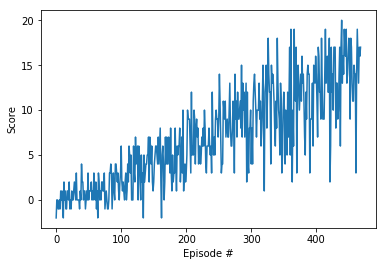

In [61]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, solved_score=13):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'trained_weights.pth')
            break
    return scores

start = time.time()
scores = dqn()
learning_took = time.time() - start

print("Learning took: {}, per episode: {}".format(learning_took, learning_took/len(scores)))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Evaluate the agent

Perform a test run for a single episode and display the total score of untrained agent. Score over 13 is considered success.

In [18]:
agent.qnetwork_local.load_state_dict(torch.load('trained_weights.pth'))

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0
for j in range(500):
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}, steps: {}".format(score, j))

Score: 18.0, steps: 299


When finished, you can close the environment.

In [10]:
env.close()